In [6]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4
from detect_heatwaves import detect

from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [7]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/india/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([8, 9])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [8]:
full_df['datetime'].max()

Timestamp('2022-07-31 00:00:00')

## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [9]:
full_df.month.unique()

array([3, 4, 5, 6, 7])

In [10]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [12]:
full_df

,Unnamed: 0,datetime,number,spatial_ref,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct
0,0,2018-03-01,0.0,0.0,3.870693,-0.336059,89.557830,3.358750,Kupwara,Jammu and Kashmir,1,3,2018,"Kupwara, Jammu and Kashmir",736754,0.092810
1,1,2018-03-02,0.0,0.0,1.752877,0.277528,96.889080,1.572616,Kupwara,Jammu and Kashmir,2,3,2018,"Kupwara, Jammu and Kashmir",736755,0.039216
2,2,2018-03-03,0.0,0.0,0.715096,-0.762714,93.343290,0.615840,Kupwara,Jammu and Kashmir,3,3,2018,"Kupwara, Jammu and Kashmir",736756,0.023529
3,3,2018-03-04,0.0,0.0,3.509904,-2.625711,88.456640,3.029944,Kupwara,Jammu and Kashmir,4,3,2018,"Kupwara, Jammu and Kashmir",736757,0.074510
4,4,2018-03-05,0.0,0.0,3.881704,-4.325170,81.862310,3.324411,Kupwara,Jammu and Kashmir,5,3,2018,"Kupwara, Jammu and Kashmir",736758,0.090196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679838,679838,2022-07-27,0.0,0.0,12.117871,7.879696,93.209750,11.345086,Kargil,Ladakh,27,7,2022,"Kargil, Ladakh",738363,0.963399
679839,679839,2022-07-28,0.0,0.0,10.570542,7.236241,93.665764,9.753105,Kargil,Ladakh,28,7,2022,"Kargil, Ladakh",738364,0.909804
679840,679840,2022-07-29,0.0,0.0,10.436489,7.206437,93.525440,9.639368,Kargil,Ladakh,29,7,2022,"Kargil, Ladakh",738365,0.905882
679841,679841,2022-07-30,0.0,0.0,10.946756,5.632615,96.131580,9.877348,Kargil,Ladakh,30,7,2022,"Kargil, Ladakh",738366,0.916340


In [14]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [15]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [16]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9006535947712418

In [17]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [18]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

733

In [19]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [20]:
codes.columns=['datetime', 'location', 'heat_ID']

In [21]:
codes.dropna(inplace=True)

In [22]:
codes

,datetime,location,heat_ID
0,2018-06-02,"Kupwara, Jammu and Kashmir",62b699af-22b3-4f3f-8920-93b8d840e528
1,2018-06-02,"Baramula, Jammu and Kashmir",345380ce-0cdb-49cd-ac2c-d8ee30444abe
2,2018-06-02,"Srinagar, Jammu and Kashmir",2ea836d9-f6d9-4de5-87d6-941528340ec4
3,2018-06-02,"Pulwama, Jammu and Kashmir",970d4690-f024-420e-b112-c0147d3ae4df
4,2018-06-02,"Punch, Jammu and Kashmir",b0815468-6270-46ec-885b-35df70887f0d
...,...,...,...
421285,2018-04-13,"Nicobars, Andaman and Nicobar Islands",33ef4efa-6a4f-425b-8559-7e05a994608f
422018,2020-03-14,"Nicobars, Andaman and Nicobar Islands",516dcb06-f67c-43f7-a5ad-afa72e8d88cd
422751,2020-03-15,"Nicobars, Andaman and Nicobar Islands",516dcb06-f67c-43f7-a5ad-afa72e8d88cd
423484,2020-04-10,"Nicobars, Andaman and Nicobar Islands",1fd793eb-a347-43a1-aaf1-ca12b6a0a589


In [23]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [24]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [25]:
consec['Heat Wave Duration'].max()

32.0

In [26]:
consec.dropna(inplace=True)

In [27]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [28]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [29]:
full_df['heat_ID'].value_counts()

a1443934-cb05-446b-8221-3cf640b79ede    32
7fe8cca3-dda3-4007-8d9f-c0de96229dfb    29
eb41d547-7fb2-4578-9457-c85972999340    28
b3a06b53-c000-4c86-9fbe-28a1c84c0107    28
d8349f25-e2f4-4ee3-825f-add504969010    27
                                        ..
7b5cbd4e-278c-48a3-bea0-ee66b77482cb     2
2d7f1170-6436-4338-b705-8316ea27616b     2
47e82bc1-e423-4c9d-9446-43ef1ad39d42     2
0736e1a5-2068-449a-904c-d764534a60c1     2
2c1173a7-b4b6-4130-9f19-d44dfddc1a67     2
Name: heat_ID, Length: 11459, dtype: int64

In [30]:
full_2022 = full_df[full_df['year'] == 2022]

In [31]:
len(full_2022['adm2'].unique())

715

In [32]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/india/clean_shp.shp')

In [33]:
len(gdf['location'].unique())

735

In [34]:
for_plot = gdf.merge(full_df.groupby(['adm2', 'adm1'])['thi'].mean().reset_index(), left_on=['adm2', 'adm1'], right_on=['adm2', 'adm1'])

<Axes: >

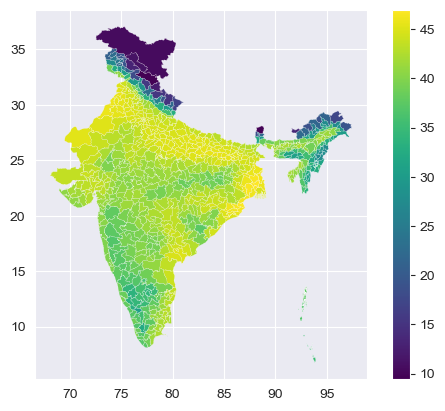

In [36]:
for_plot.plot(column='thi', legend=True, cmap='viridis', linewidth=0.1)


In [37]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/india/THI_india_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/india/THI_india_90_2018_2022.csv')

In [67]:
full_2022['heatwave'].unique()

array([1.])